# What Drives the Price of a Car?

### Overview

A used car dealership wants to understand what factors make a car more or less expensive. Using a dataset of 426,000 used car listings, this notebook walks through the CRISP-DM process to identify the key drivers of used car prices and provide actionable recommendations.

**CRISP-DM Steps:**
1. Business Understanding
2. Data Understanding
3. Data Preparation
4. Modeling
5. Evaluation
6. Findings / Deployment

## 1. Business Understanding

**Goal:** Help a used car dealership understand what features consumers value most in a used car, so they can make better decisions about pricing and inventory.

**Key Question:** What factors drive the price of a used car up or down?

## 2. Data Understanding

In [28]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Plot settings
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

In [29]:
# Load data
df = pd.read_csv('data/vehicles.csv')
print("Shape:", df.shape)
df.head()

Shape: (426880, 18)


,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [30]:
# Check data types and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [31]:
# Summary stats
df.describe()

,id,price,year,odometer
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07


In [32]:
# How many missing values per column?
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(1)
missing_summary = pd.DataFrame({'Missing': missing, 'Percent': missing_pct})
missing_summary[missing_summary['Missing'] > 0].sort_values('Percent', ascending=False)

,Missing,Percent
size,306361,71.8
cylinders,177678,41.6
condition,174104,40.8
VIN,161042,37.7
drive,130567,30.6
paint_color,130203,30.5
type,92858,21.8
manufacturer,17646,4.1
title_status,8242,1.9
model,5277,1.2


## 3. Data Preparation

The data needs cleaning before we can model it. We need to:
- Remove unrealistic prices (e.g., $0 or millions)
- Handle missing values
- Drop columns that won't help with modeling
- Create a vehicle age feature

In [33]:
# Check price range - there are some crazy values
print("Price range before cleaning:")
print(f"  Min: ${df['price'].min():,}")
print(f"  Max: ${df['price'].max():,}")
print(f"  Cars priced at $0: {(df['price'] == 0).sum():,}")
print(f"  Cars priced over $100k: {(df['price'] > 100000).sum():,}")

Price range before cleaning:
  Min: $0
  Max: $3,736,928,711
  Cars priced at $0: 32,895
  Cars priced over $100k: 655


In [34]:
# Keep only cars with realistic prices ($500 to $100,000)
df = df[(df['price'] >= 500) & (df['price'] <= 100000)]
print(f"Rows after price filter: {len(df):,}")

Rows after price filter: 384,131


In [35]:
# Remove rows with missing or extreme odometer values
df = df[(df['odometer'].notna()) & (df['odometer'] <= 500000)]
print(f"Rows after odometer filter: {len(df):,}")

Rows after odometer filter: 380,871


In [36]:
# Create vehicle age and remove unreasonable years
df = df[df['year'].notna()]
df['age'] = 2025 - df['year']
df = df[(df['age'] >= 0) & (df['age'] <= 50)]
print(f"Rows after year filter: {len(df):,}")

Rows after year filter: 373,454


In [37]:
# Drop columns we don't need for modeling
# id, VIN - just identifiers
# region - too many categories, state is enough
# model - 29,000+ unique values, too many
# size - over 70% missing
# year - replaced by age

df = df.drop(columns=['id', 'VIN', 'region', 'model', 'size', 'year'])
print("Remaining columns:", df.columns.tolist())

Remaining columns: ['price', 'manufacturer', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'type', 'paint_color', 'state', 'age']


In [38]:
# Drop any remaining rows with missing values
print(f"Before dropping nulls: {len(df):,}")
df = df.dropna()
print(f"After dropping nulls: {len(df):,}")

Before dropping nulls: 373,454
After dropping nulls: 108,679


After dropping nulls: 108,679


## 4. Exploratory Data Analysis

Let's explore the data visually to understand the relationships between features and price.

### Price Distribution

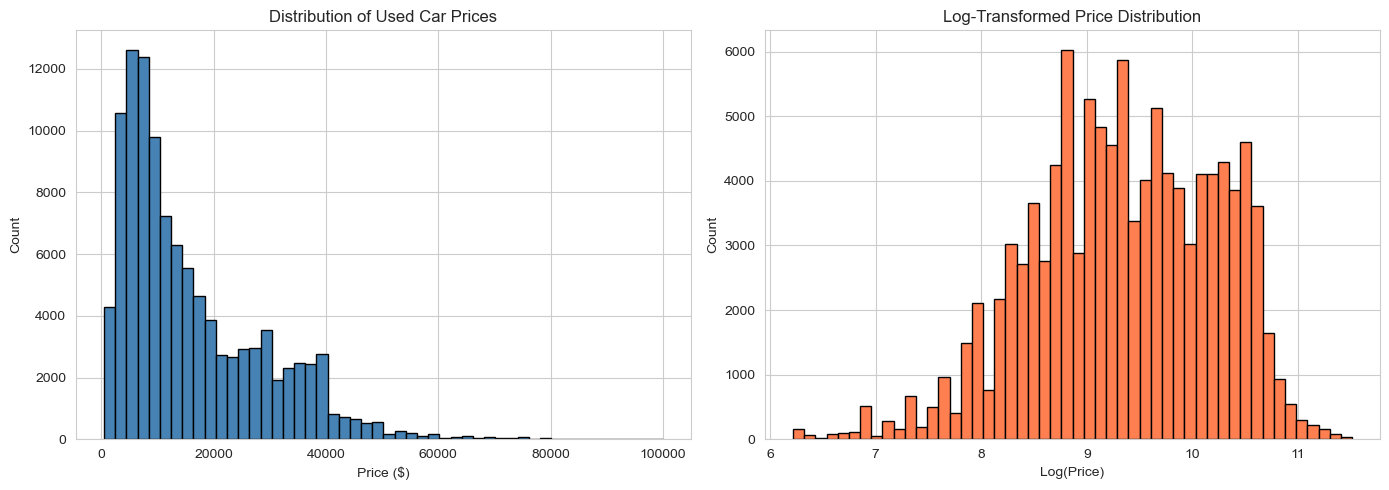

Median price: $11,800
Mean price: $16,075


In [39]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df['price'], bins=50, edgecolor='black', color='steelblue')
axes[0].set_xlabel('Price ($)')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Used Car Prices')

axes[1].hist(np.log1p(df['price']), bins=50, edgecolor='black', color='coral')
axes[1].set_xlabel('Log(Price)')
axes[1].set_ylabel('Count')
axes[1].set_title('Log-Transformed Price Distribution')

plt.tight_layout()
plt.show()

print(f"Median price: ${df['price'].median():,.0f}")
print(f"Mean price: ${df['price'].mean():,.0f}")

### Continuous Variables vs. Price

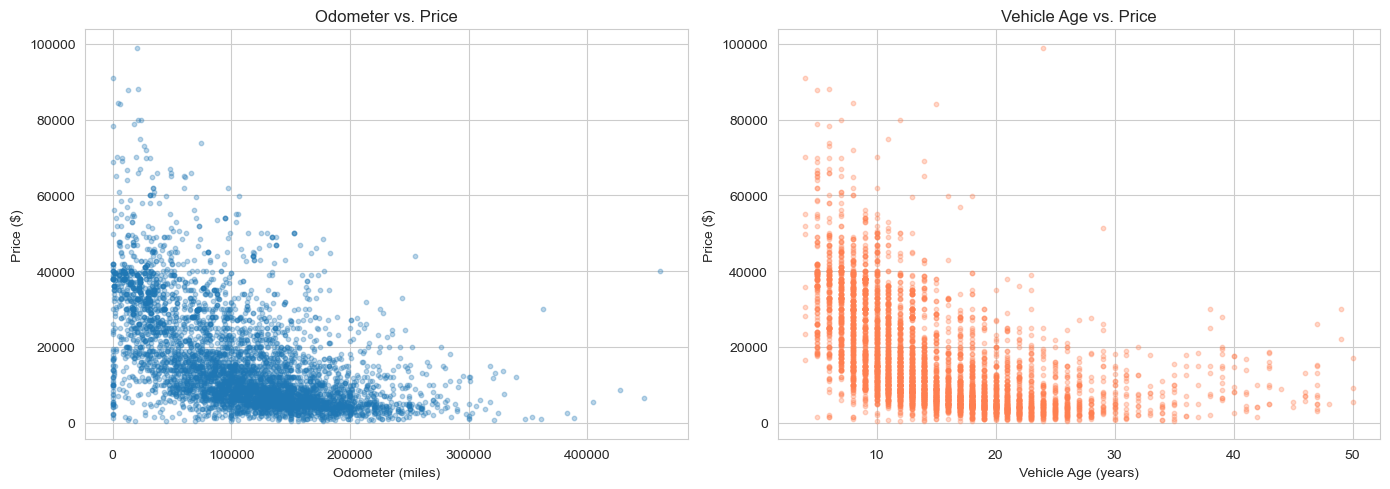

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Sample 5000 points so scatter plots aren't too crowded
sample = df.sample(5000, random_state=42)

axes[0].scatter(sample['odometer'], sample['price'], alpha=0.3, s=10)
axes[0].set_xlabel('Odometer (miles)')
axes[0].set_ylabel('Price ($)')
axes[0].set_title('Odometer vs. Price')

axes[1].scatter(sample['age'], sample['price'], alpha=0.3, s=10, color='coral')
axes[1].set_xlabel('Vehicle Age (years)')
axes[1].set_ylabel('Price ($)')
axes[1].set_title('Vehicle Age vs. Price')

plt.tight_layout()
plt.show()

### Correlation Heatmap

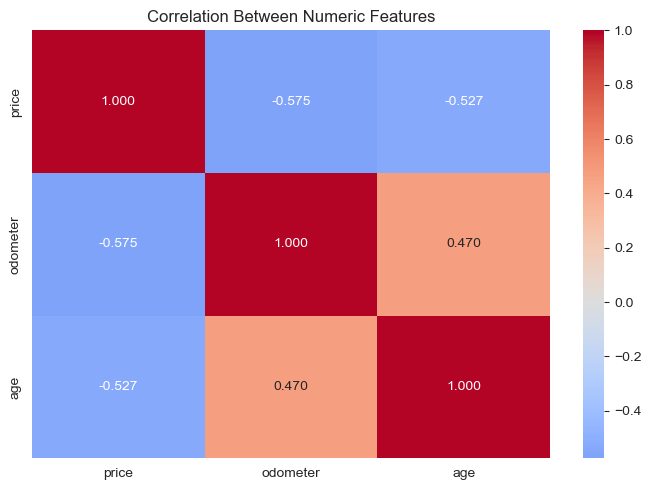

In [41]:
corr = df[['price', 'odometer', 'age']].corr()

plt.figure(figsize=(7, 5))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt='.3f')
plt.title('Correlation Between Numeric Features')
plt.tight_layout()
plt.show()

### Categorical Variables vs. Price

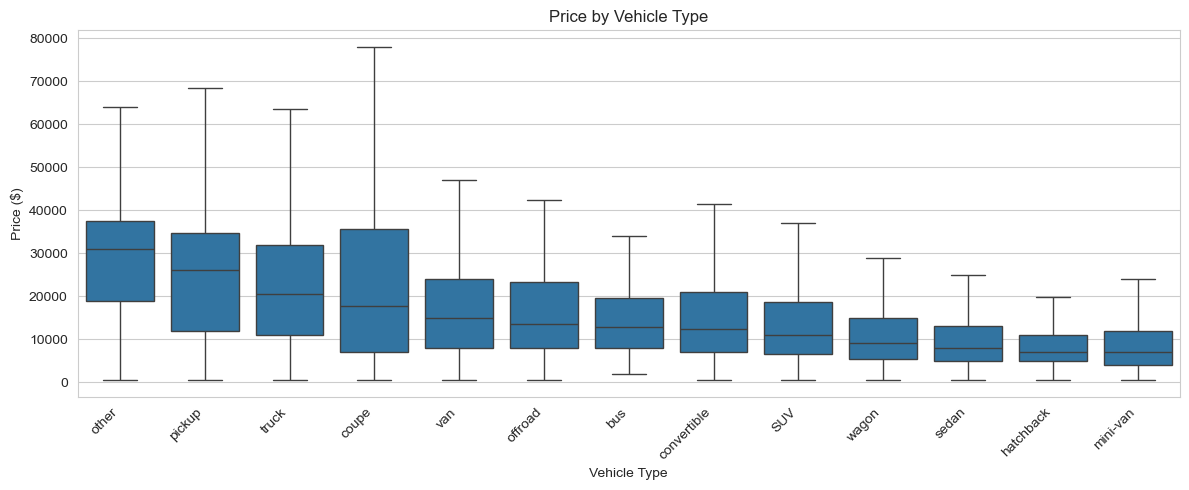

In [42]:
# Vehicle Type
fig, ax = plt.subplots(figsize=(12, 5))
order = df.groupby('type')['price'].median().sort_values(ascending=False).index
sns.boxplot(data=df, x='type', y='price', order=order, showfliers=False)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Vehicle Type')
plt.ylabel('Price ($)')
plt.title('Price by Vehicle Type')
plt.tight_layout()
plt.show()

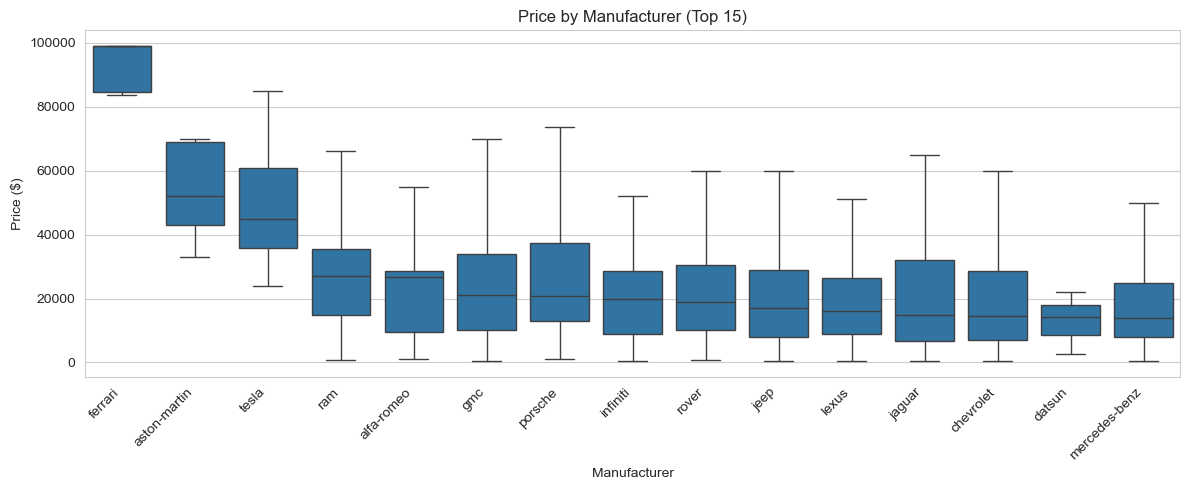

In [43]:
# Top 15 Manufacturers by median price
fig, ax = plt.subplots(figsize=(12, 5))
top15 = df.groupby('manufacturer')['price'].median().nlargest(15).index
order = df[df['manufacturer'].isin(top15)].groupby('manufacturer')['price'].median().sort_values(ascending=False).index
sns.boxplot(data=df[df['manufacturer'].isin(top15)], x='manufacturer', y='price', 
            order=order, showfliers=False)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Manufacturer')
plt.ylabel('Price ($)')
plt.title('Price by Manufacturer (Top 15)')
plt.tight_layout()
plt.show()

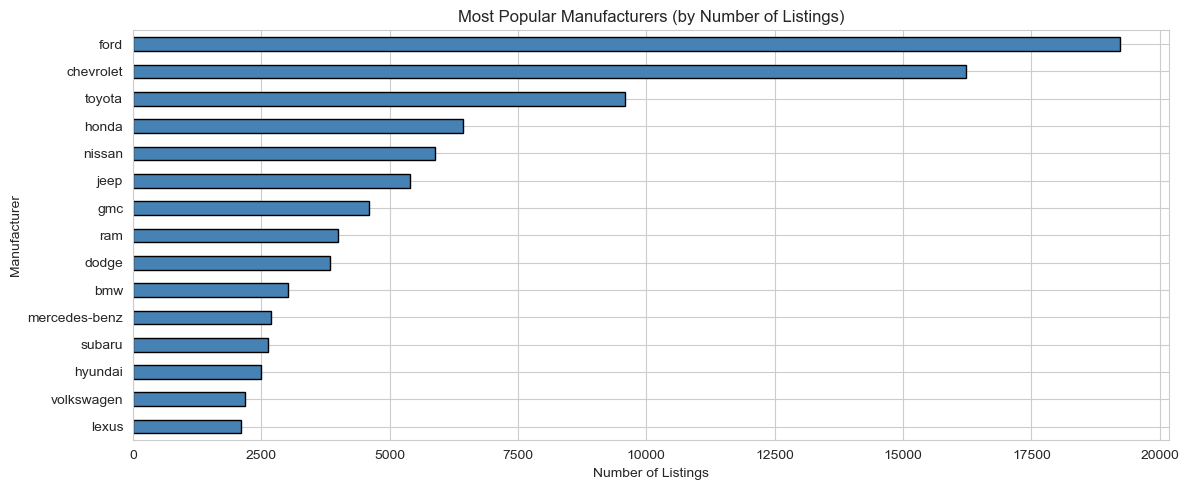

Ford, Chevrolet, and Toyota have the most listings by far.
They are mid-range in price but dominate the market in volume.


In [44]:
# Top 15 Manufacturers by number of listings (most popular brands)
fig, ax = plt.subplots(figsize=(12, 5))
top15_count = df['manufacturer'].value_counts().head(15)
top15_count.plot(kind='barh', ax=ax, color='steelblue', edgecolor='black')
plt.xlabel('Number of Listings')
plt.ylabel('Manufacturer')
plt.title('Most Popular Manufacturers (by Number of Listings)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print('Ford, Chevrolet, and Toyota have the most listings by far.')
print('They are mid-range in price but dominate the market in volume.')

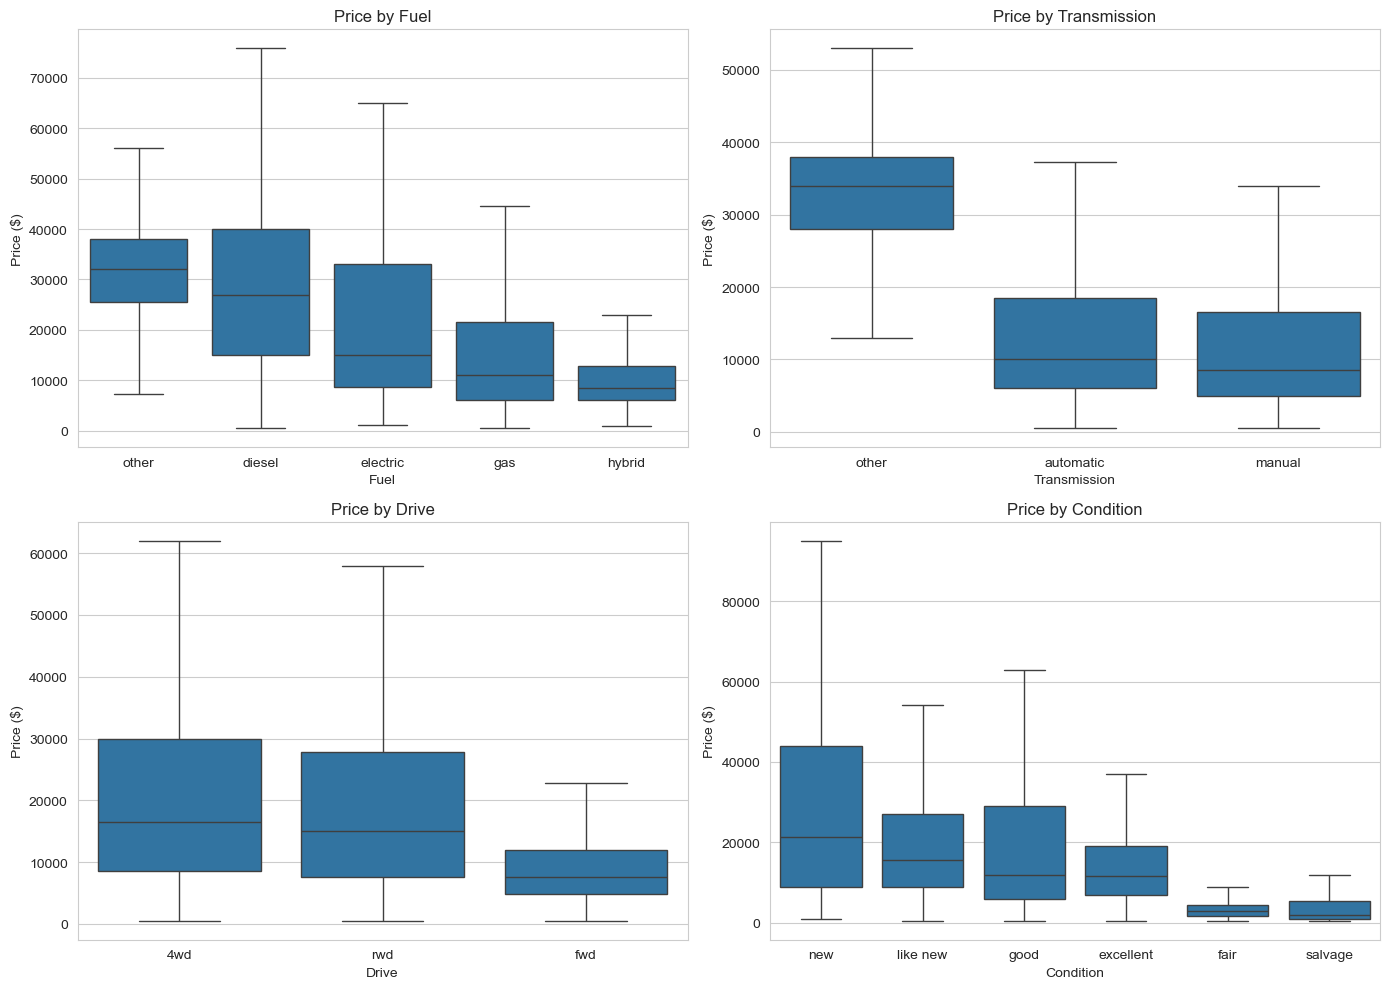

In [45]:
# Fuel, Transmission, Drive, Condition - all in one figure
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for ax, col in zip(axes.flatten(), ['fuel', 'transmission', 'drive', 'condition']):
    order = df.groupby(col)['price'].median().sort_values(ascending=False).index
    sns.boxplot(data=df, x=col, y='price', order=order, ax=ax, showfliers=False)
    ax.set_title(f'Price by {col.title()}')
    ax.set_xlabel(col.title())
    ax.set_ylabel('Price ($)')

plt.tight_layout()
plt.show()

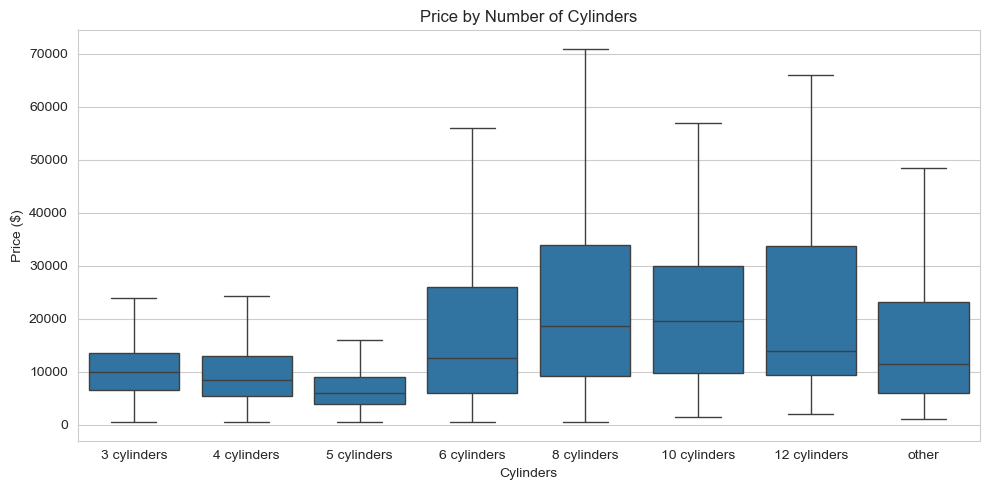

In [46]:
# Cylinders
fig, ax = plt.subplots(figsize=(10, 5))
cyl_order = ['3 cylinders', '4 cylinders', '5 cylinders', '6 cylinders', 
             '8 cylinders', '10 cylinders', '12 cylinders', 'other']
cyl_order = [c for c in cyl_order if c in df['cylinders'].unique()]
sns.boxplot(data=df, x='cylinders', y='price', order=cyl_order, showfliers=False)
plt.xlabel('Cylinders')
plt.ylabel('Price ($)')
plt.title('Price by Number of Cylinders')
plt.tight_layout()
plt.show()

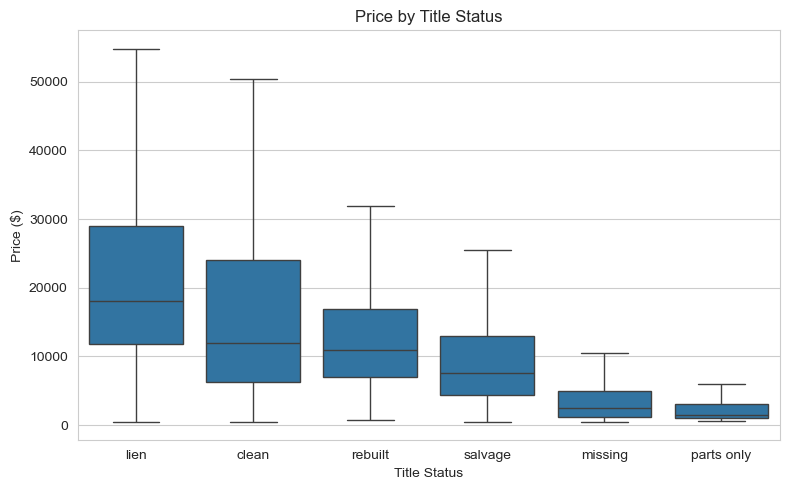

In [47]:
# Title Status
fig, ax = plt.subplots(figsize=(8, 5))
order = df.groupby('title_status')['price'].median().sort_values(ascending=False).index
sns.boxplot(data=df, x='title_status', y='price', order=order, showfliers=False)
plt.xlabel('Title Status')
plt.ylabel('Price ($)')
plt.title('Price by Title Status')
plt.tight_layout()
plt.show()

## 5. Modeling

We'll try three regression models and compare them. 

**Evaluation Metric:** Mean Absolute Error (MAE) — this tells us the average dollar amount our prediction is off by, which is easy to understand.

### Prepare Data for Modeling

In [48]:
# Select features
features = ['manufacturer', 'condition', 'cylinders', 'fuel', 
            'odometer', 'title_status', 'transmission', 'drive', 'type', 'age']

df_model = df[features + ['price']].copy()

X = df_model.drop('price', axis=1)
y = df_model['price']

# Split into categorical and numerical
cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = X.select_dtypes(include='number').columns.tolist()

print(f"Categorical features: {cat_cols}")
print(f"Numerical features: {num_cols}")

Categorical features: ['manufacturer', 'condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'drive', 'type']
Numerical features: ['odometer', 'age']


In [49]:
# Build a preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), cat_cols)
])

# Split data 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training: {len(X_train):,} rows")
print(f"Testing: {len(X_test):,} rows")

Training: 86,943 rows
Testing: 21,736 rows


### Model 1: Linear Regression

In [50]:
lr_pipe = Pipeline([('prep', preprocessor), ('model', LinearRegression())])

# 5-fold cross validation
lr_cv = cross_val_score(lr_pipe, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')

# Fit and predict
lr_pipe.fit(X_train, y_train)
lr_pred = lr_pipe.predict(X_test)

print("Linear Regression Results:")
print(f"  CV MAE:   ${-lr_cv.mean():,.0f}")
print(f"  Test MAE: ${mean_absolute_error(y_test, lr_pred):,.0f}")
print(f"  Test R²:  {r2_score(y_test, lr_pred):.4f}")

Linear Regression Results:
  CV MAE:   $4,575
  Test MAE: $4,585
  Test R²:  0.7348


### Model 2: Ridge Regression (with Grid Search)

In [51]:
ridge_pipe = Pipeline([('prep', preprocessor), ('model', Ridge())])

# Try different alpha values
params = {'model__alpha': [0.1, 1, 10, 100, 1000]}
ridge_grid = GridSearchCV(ridge_pipe, params, cv=5, scoring='neg_mean_absolute_error')
ridge_grid.fit(X_train, y_train)

ridge_pred = ridge_grid.predict(X_test)

print("Ridge Regression Results:")
print(f"  Best alpha: {ridge_grid.best_params_['model__alpha']}")
print(f"  CV MAE:   ${-ridge_grid.best_score_:,.0f}")
print(f"  Test MAE: ${mean_absolute_error(y_test, ridge_pred):,.0f}")
print(f"  Test R²:  {r2_score(y_test, ridge_pred):.4f}")

Ridge Regression Results:
  Best alpha: 0.1
  CV MAE:   $4,575
  Test MAE: $4,585
  Test R²:  0.7348


### Model 3: Lasso Regression (with Grid Search)

In [52]:
lasso_pipe = Pipeline([('prep', preprocessor), ('model', Lasso(max_iter=10000))])

params = {'model__alpha': [0.1, 1, 10, 100, 1000]}
lasso_grid = GridSearchCV(lasso_pipe, params, cv=5, scoring='neg_mean_absolute_error')
lasso_grid.fit(X_train, y_train)

lasso_pred = lasso_grid.predict(X_test)

print("Lasso Regression Results:")
print(f"  Best alpha: {lasso_grid.best_params_['model__alpha']}")
print(f"  CV MAE:   ${-lasso_grid.best_score_:,.0f}")
print(f"  Test MAE: ${mean_absolute_error(y_test, lasso_pred):,.0f}")
print(f"  Test R²:  {r2_score(y_test, lasso_pred):.4f}")

Lasso Regression Results:
  Best alpha: 0.1
  CV MAE:   $4,575
  Test MAE: $4,585
  Test R²:  0.7348


### Model Comparison

In [53]:
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Ridge', 'Lasso'],
    'Test MAE ($)': [
        mean_absolute_error(y_test, lr_pred),
        mean_absolute_error(y_test, ridge_pred),
        mean_absolute_error(y_test, lasso_pred)
    ],
    'Test R²': [
        r2_score(y_test, lr_pred),
        r2_score(y_test, ridge_pred),
        r2_score(y_test, lasso_pred)
    ]
})
print(results.to_string(index=False))

            Model  Test MAE ($)  Test R²
Linear Regression   4584.980627 0.734826
            Ridge   4585.047697 0.734819
            Lasso   4584.936435 0.734798


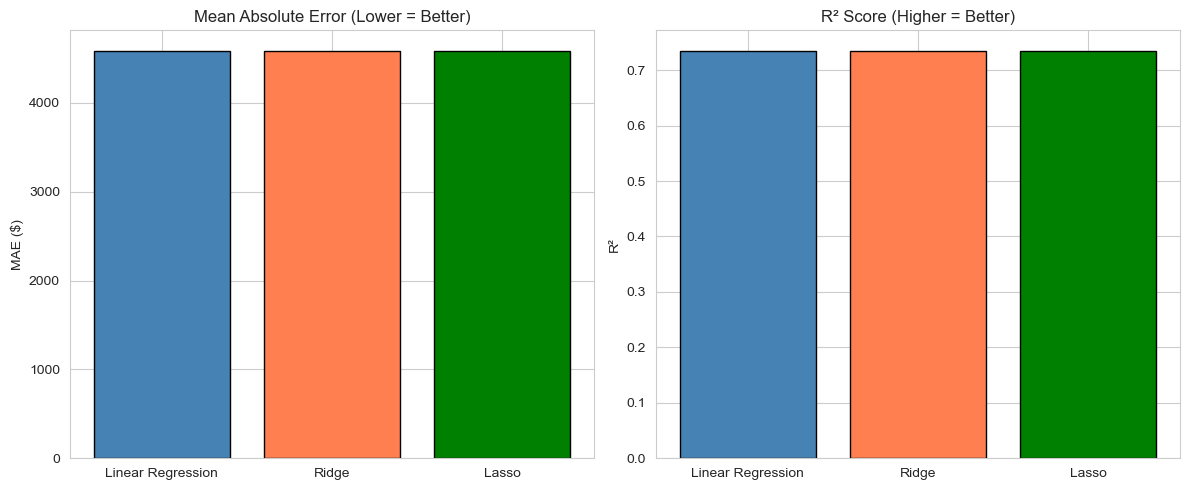

In [56]:
# Visual comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].bar(results['Model'], results['Test MAE ($)'], color=['steelblue', 'coral', 'green'], edgecolor='black')
axes[0].set_ylabel('MAE ($)')
axes[0].set_title('Mean Absolute Error (Lower = Better)')

axes[1].bar(results['Model'], results['Test R²'], color=['steelblue', 'coral', 'green'], edgecolor='black')
axes[1].set_ylabel('R²')
axes[1].set_title('R² Score (Higher = Better)')

plt.tight_layout()
plt.show()

## 6. Evaluation

### Which features matter most?

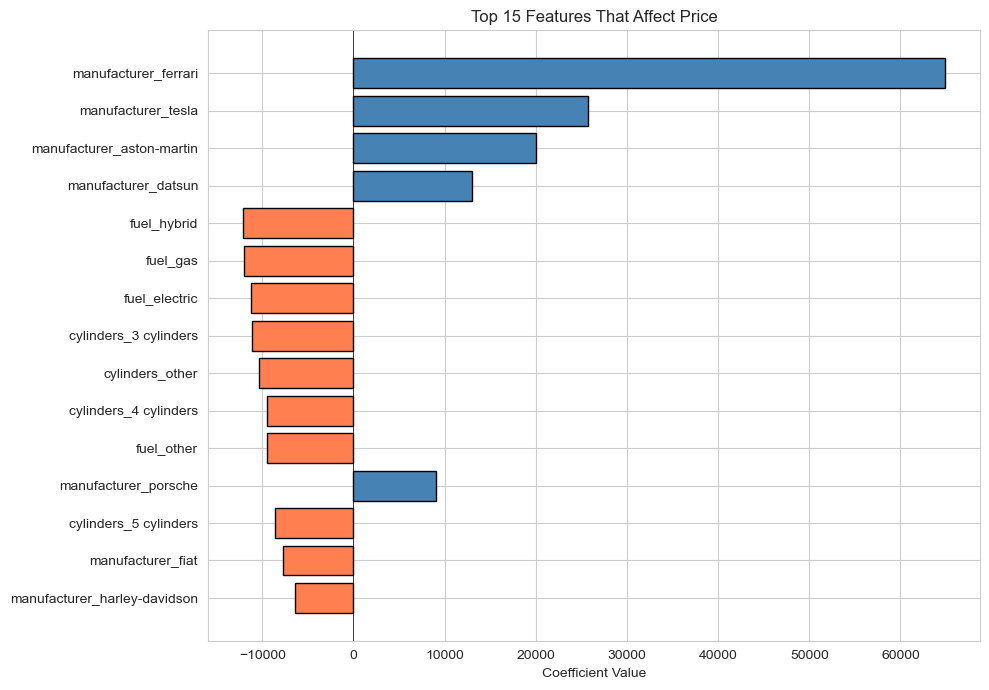

Blue = increases price, Red = decreases price


In [57]:
# Get coefficients from the best Ridge model
best = ridge_grid.best_estimator_

# Feature names after encoding
cat_names = best.named_steps['prep'].named_transformers_['cat'].get_feature_names_out(cat_cols).tolist()
all_names = num_cols + cat_names
coefs = best.named_steps['model'].coef_

# Top 15 by absolute value
coef_df = pd.DataFrame({'Feature': all_names, 'Coefficient': coefs})
coef_df['abs'] = coef_df['Coefficient'].abs()
top15 = coef_df.nlargest(15, 'abs')

plt.figure(figsize=(10, 7))
colors = ['coral' if c < 0 else 'steelblue' for c in top15['Coefficient']]
plt.barh(range(len(top15)), top15['Coefficient'].values, color=colors, edgecolor='black')
plt.yticks(range(len(top15)), top15['Feature'].values)
plt.xlabel('Coefficient Value')
plt.title('Top 15 Features That Affect Price')
plt.gca().invert_yaxis()
plt.axvline(x=0, color='black', linewidth=0.5)
plt.tight_layout()
plt.show()

print("Blue = increases price, Red = decreases price")

## 7. Findings and Recommendations

### What drives used car prices?

Based on our analysis, here are the **top factors** that affect used car prices:

**Factors that INCREASE price:**
- **Newer cars** — Age is one of the biggest factors. Cars under 5 years old have a median price of ~37,900, compared to ~5,000 for cars over 20 years old.
- **Low mileage** — Cars under 25,000 miles have a median price of ~34,000. Over 200,000 miles, the median drops to ~5,000.
- **Pickup trucks** — Pickups have the highest median price ~26,000 among standard vehicle types, followed by trucks ~20,500.
- **Diesel fuel** — Diesel vehicles have a median price of ~27,000, more than double the ~11,000 for gas vehicles.
- **4WD drive** — 4WD vehicles (16,500 median) are priced higher than FWD (7,500 median).
- **More cylinders** — 8-cylinder (18,700) and 10-cylinder (19,500) vehicles command higher prices than 4-cylinder (8,450).
- **Clean title** — Clean title vehicles (11,900) are worth far more than salvage (7,650) or parts-only (1,500).

**Factors that DECREASE price:**
- **High mileage** — Strong negative correlation (-0.58) with price.
- **Older age** — Strong negative correlation (-0.53) with price.
- **Salvage/rebuilt condition** — Salvage condition cars have a median of just 2,000.
- **Sedans and hatchbacks** — Median prices of 7,900 and 7,000, much lower than pickups and trucks.

### Recommendations for the Dealership

1. **Stock newer, low-mileage cars** — These two factors have the strongest correlation with price. Cars under 5 years old and under 50,000 miles will have the best margins.
2. **Invest in pickups and trucks** — Pickups (26,000 median) and trucks (20,500) consistently outsell sedans (7,900) in price.
3. **Look for diesel vehicles** — Diesel commands a significant premium (27,000 vs 11,000 for gas), likely due to demand in trucks and commercial vehicles.
4. **Prioritize 4WD vehicles** — 4WD (16,500) is priced higher than FWD (7,500) and even RWD (15,000).
5. **Avoid salvage title or salvage condition vehicles** — Both carry steep price penalties that are hard to recover from.
6. **Consider high-volume brands** — Ford, Chevrolet, and Toyota have the most listings in the dataset, suggesting strong market presence. While they are mid-range in price, stocking well-known brands may appeal to a wider pool of buyers.

### Next Steps
- Try more advanced models (Random Forest, Gradient Boosting) to capture non-linear relationships.
- Build separate models for different vehicle types (trucks vs. sedans) for more accurate pricing.
- Add features like trim level and vehicle history for better predictions.